<font color='green'> Data Science with Marco - Youtube kanalında [Anomaly detection in time series with Python](https://www.youtube.com/watch?v=qy41dXGbAxY) videosunda Marco Peixeiro time series datasında Anomaly Detection'ı uygulamalı olarak anlattı. </font> 

## <font color='black'> İçindekiler</font>

1. AWS bulutundaki bir EC2 bulut sunucusunun CPU kullanımına ilişkin gerçek hayat verilerini okuyoruz.
2. Hangi değerlerin gerçekte anomali olduğuna dair bilgiyi ekliyoruz. Median Absolute Deviation, Isolation Forest ve Local outlier factor (LOF) ile bu anomalileri yakalayıp yakalayamadığımıza bakacağız. 
3. Median Absolute Deviation'ı uyguluyoruz.
    - Datanın dağılımı normal dağılıma yakın olduğu zaman ve MAD değeri 0 olmadığı zaman bu metodu kullanabiliyoruz. Bu yüzden önce datanın dağılımını ve medianını kontrol ediyoruz.
    - MAD ile hangi değerlerin anomali olduğunu bulup confusion matris ile gerçekleşen ve tahminimizi karşılaştırıyoruz.
4. Isolation Forest'ı uyguluyoruz.
    - Algoritmanın başarısını anlayabilmek için elimizdeki datayı bir anomali değer trainde diğeri testte kalacak şekilde ikiye böldük. 
    - Train datasıyla modeli eğittik. Contaminationımızı da train datamızda 1 anomali olduğu için 1/len(df_train) olarak verdik. 
    - Eğittiğimiz bu model Test datamızda nasıl sonuç verecek diye bakmak için model.predict() içerisinde datamızı veriyoruz. 
    - predict() fonksiyonundan çıkan anomali-normal çıktısıyla gerçek datamızın çıktısını karşılaştırıyoruz ve confusion matris oluşturuyoruz.
5. Local Outlier Factor'u uyguluyoruz.
    - Algoritmanın başarısını anlayabilmek için elimizdeki datayı bir anomali değer trainde diğeri testte kalacak şekilde ikiye böldük. 
    - Train datasıyla modeli eğittik. Contaminationımızı da train datamızda 1 anomali olduğu için 1/len(df_train) olarak verdik. 
    - Eğittiğimiz bu model Test datamızda nasıl sonuç verecek diye bakmak için model.predict() içerisinde datamızı veriyoruz. 
    - predict() fonksiyonundan çıkan anomali-normal çıktısıyla gerçek datamızın çıktısını karşılaştırıyoruz ve confusion matris oluşturuyoruz.

# <font color='black'> Anomaly detection in time series </font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)

%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (9,6)

## <font color='blue'>Read the data</font>

The dataset can be downloaded from [GitHub](https://github.com/numenta/NAB/blob/master/data/realAWSCloudwatch/ec2_cpu_utilization_24ae8d.csv)

The labels can be obtained from [GitHub](https://github.com/numenta/NAB/blob/master/labels/combined_labels.json)

This is real-life data on CPU utilization of an EC2 instance in the AWS cloud. Data was recorded every 5 minutes, starting on February 14th at 14:30. The dataset contains 4032 data points. It is available through the Numenta Anomaly Benchmark (NAB) repository under the AGPL-3.0 license.

In [3]:
df = pd.read_csv('./data/ec2_cpu_utilization.csv') # Downloaded from the link above (ec2_cpu_utilization_24ae8d.csv)
df.head()

,timestamp,value
0,2014-02-14 14:30:00,0.132
1,2014-02-14 14:35:00,0.134
2,2014-02-14 14:40:00,0.134
3,2014-02-14 14:45:00,0.134
4,2014-02-14 14:50:00,0.134


In [4]:
df.shape

(4032, 2)

**Gerçekte 2 data noktasını anomali olarak biliyoruz biz.** 

In [5]:
# Labels taken from the link above. We are looking at the labels for ec2_cpu_utilization_24ae8d dataset

anomalies_timestamp = [
        "2014-02-26 22:05:00",
        "2014-02-27 17:15:00"
    ]

**timestamp sütunu normalde timestamp değil string, onu timestampe çeviriyoruz.**

In [6]:
type(df.loc[0]['timestamp']) 

str

In [7]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

df.head()

,timestamp,value
0,2014-02-14 14:30:00,0.132
1,2014-02-14 14:35:00,0.134
2,2014-02-14 14:40:00,0.134
3,2014-02-14 14:45:00,0.134
4,2014-02-14 14:50:00,0.134


In [8]:
type(df.loc[0]['timestamp']) 

pandas._libs.tslibs.timestamps.Timestamp

**is_anomaly etiketi ekliyoruz. İki tane anomali data pointimiz vardı. Bunların olduğu yere -1 gerisine 1 diyoruz. Sklearnde de normal değerler 1 anomaliler -1 oluyor.**

In [9]:
df['is_anomaly'] = 1

for each in anomalies_timestamp:
    df.loc[df['timestamp'] == each, 'is_anomaly'] = -1
    
df.head()

,timestamp,value,is_anomaly
0,2014-02-14 14:30:00,0.132,1
1,2014-02-14 14:35:00,0.134,1
2,2014-02-14 14:40:00,0.134,1
3,2014-02-14 14:45:00,0.134,1
4,2014-02-14 14:50:00,0.134,1


**Grafikteki gösterimi için filtreledikten sonra `reset_index(drop=True)`yapmamalıyız. İndeksi yazıyor x ekseninde grafikte.**

In [10]:
anomaly_df = df.loc[df['is_anomaly'] == -1]
inlier_df = df.loc[df['is_anomaly'] == 1]

**İki ayrı dataframe'e ayırdığımız normal ve anormal değerleri aynı grafikte görselleştiriyoruz.**

In [11]:
df.shape

(4032, 3)

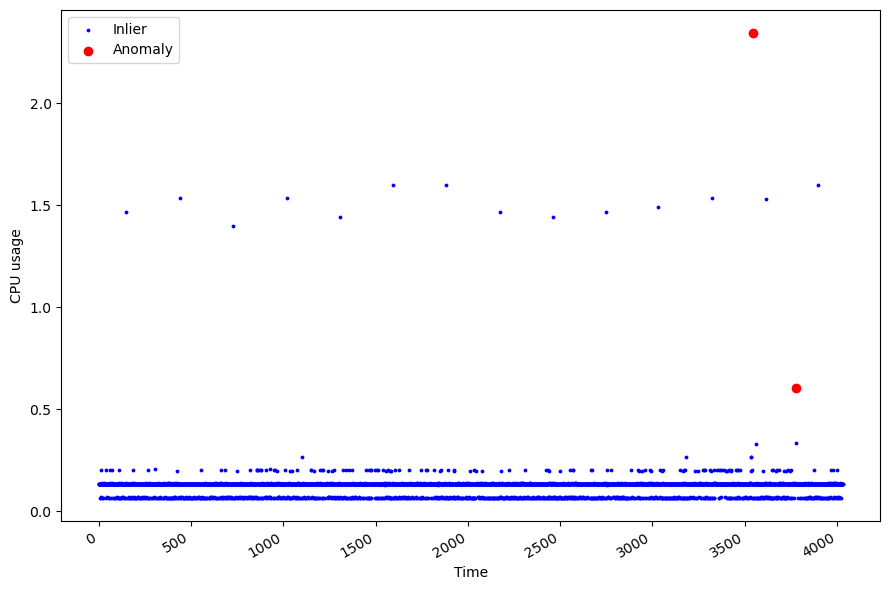

In [12]:
fig, ax = plt.subplots()

ax.scatter(inlier_df.index, inlier_df['value'], color='blue', s=3, label='Inlier')
ax.scatter(anomaly_df.index, anomaly_df['value'], color='red', label='Anomaly')
ax.set_xlabel('Time')
ax.set_ylabel('CPU usage')
ax.legend(loc=2)

plt.grid(False)
fig.autofmt_xdate()
plt.tight_layout()

In [13]:
inlier_df.head()

,timestamp,value,is_anomaly
0,2014-02-14 14:30:00,0.132,1
1,2014-02-14 14:35:00,0.134,1
2,2014-02-14 14:40:00,0.134,1
3,2014-02-14 14:45:00,0.134,1
4,2014-02-14 14:50:00,0.134,1


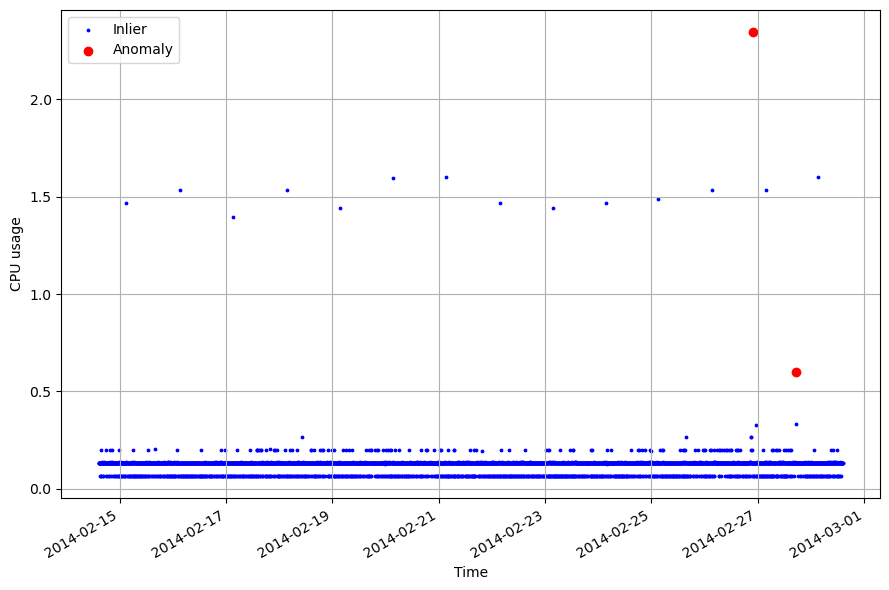

In [14]:
fig, ax = plt.subplots()

ax.scatter(inlier_df['timestamp'], inlier_df['value'], color='blue', s=3, label='Inlier')
ax.scatter(anomaly_df['timestamp'], anomaly_df['value'], color='red', label='Anomaly')
ax.set_xlabel('Time')
ax.set_ylabel('CPU usage')
ax.legend(loc=2)

plt.grid(True)
fig.autofmt_xdate()
plt.tight_layout()

In [15]:
df['value'].describe()

count    4032.000000
mean        0.126303
std         0.094813
min         0.066000
25%         0.132000
50%         0.134000
75%         0.134000
max         2.344000
Name: value, dtype: float64

## <font color='blue'>Baseline: median absolute deviation (MAD) </font>

<font color='black'>**Datanın dağılımı normal dağılıma yakın olduğu zaman ve MAD değeri 0 olmadığı zaman bu metodu kullanabiliyoruz.**</font>

**Datamızın dağılımına bakıyoruz.**

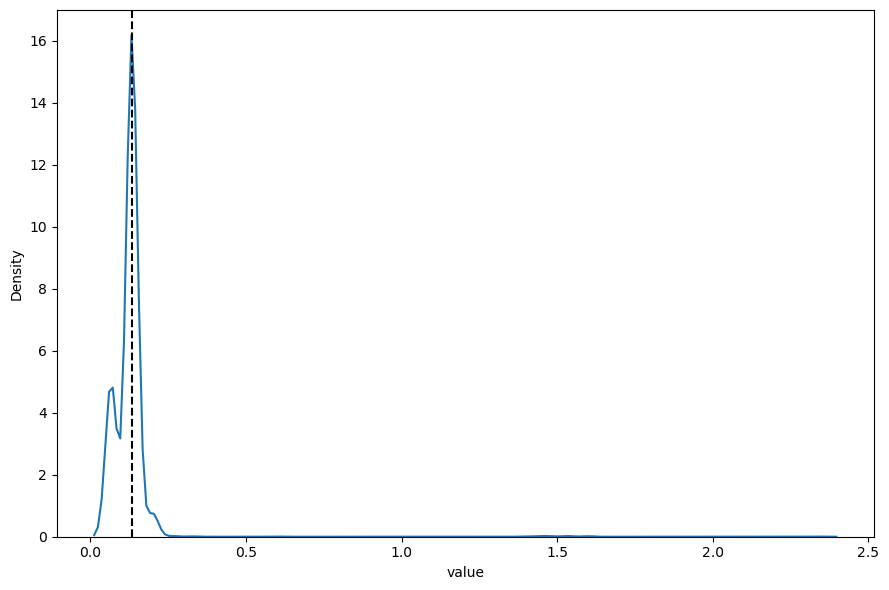

In [16]:
import seaborn as sns

sns.kdeplot(df['value']);
plt.grid(False)
plt.axvline(0.134, 0, 1, c='black', ls='--') 
plt.tight_layout()

**Dik kesikli çizgi medianı ifade ediyor. Çok fazla datanın mediana denk geldiğini görüyoruz. Yani 2. dikkat etmemiz gereken durum için kırmızı bayrak kalkmış oldu. Dağılım sola doğru çok çarpık. Normal dağılım kuralına da uymuyor. Muhtemelen iyi çalışmayacak burada median absolute deviation.**

In [17]:
df.head()

,timestamp,value,is_anomaly
0,2014-02-14 14:30:00,0.132,1
1,2014-02-14 14:35:00,0.134,1
2,2014-02-14 14:40:00,0.134,1
3,2014-02-14 14:45:00,0.134,1
4,2014-02-14 14:50:00,0.134,1


#### *median_abs_deviation hazır fonksiyonu kullanmak yerine kendim bu şekilde de hesaplayabilirdim Mean Absolute Deviation'ı.* 

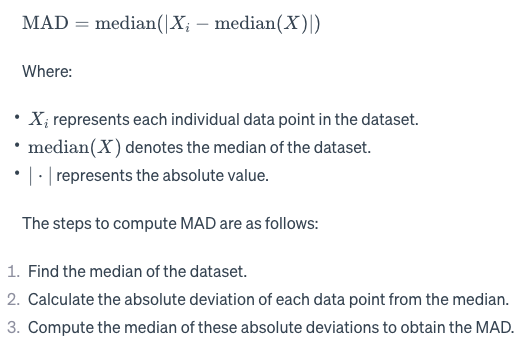

In [18]:
# df2 = df.copy()
# df2['value-median'] = abs(df2['value'] - df2['value'].median())
# mad2 = df2['value-median'].median()
# mad2

#### 

In [20]:
from scipy.stats import median_abs_deviation

mad = median_abs_deviation(df['value'])
median = np.median(df['value'])

print(median)
print(mad)

def compute_robust_z_score(x):
    return .6745*(x-median)/mad

0.134
0.0020000000000000018


**MAD değeri 0 çıkmadı ama 0'a çok yakın çıktı (Demek ki değerlerin çoğu birbiriyle aynı). MAD değeri çok küçük olduğu için medianın biraz dışında olan herhangi bir nokta (büyüyecek bu durumda eşitlik, payda çok küçük 0.002 olduğu için-payı 500 ile çarpıyoruz.) direkt outlier diye etiketlenecek.**

In [21]:
df['z-score'] = df['value'].apply(compute_robust_z_score)

df.head()

,timestamp,value,is_anomaly,z-score
0,2014-02-14 14:30:00,0.132,1,-0.6745
1,2014-02-14 14:35:00,0.134,1,0.0000
2,2014-02-14 14:40:00,0.134,1,0.0000
3,2014-02-14 14:45:00,0.134,1,0.0000
4,2014-02-14 14:50:00,0.134,1,0.0000


**z-score değeri 3.5'tan büyük veya -3.5'tan küçük olanları anomali olarak etiketliyorum.**

In [22]:
df['baseline'] = 1

df.loc[df['z-score'] >= 3.5, 'baseline'] = -1
df.loc[df['z-score'] <=-3.5, 'baseline'] = -1

In [23]:
df.head()

,timestamp,value,is_anomaly,z-score,baseline
0,2014-02-14 14:30:00,0.132,1,-0.6745,1
1,2014-02-14 14:35:00,0.134,1,0.0000,1
2,2014-02-14 14:40:00,0.134,1,0.0000,1
3,2014-02-14 14:45:00,0.134,1,0.0000,1
4,2014-02-14 14:50:00,0.134,1,0.0000,1


### <font color='black'>**Evaluation**</font>

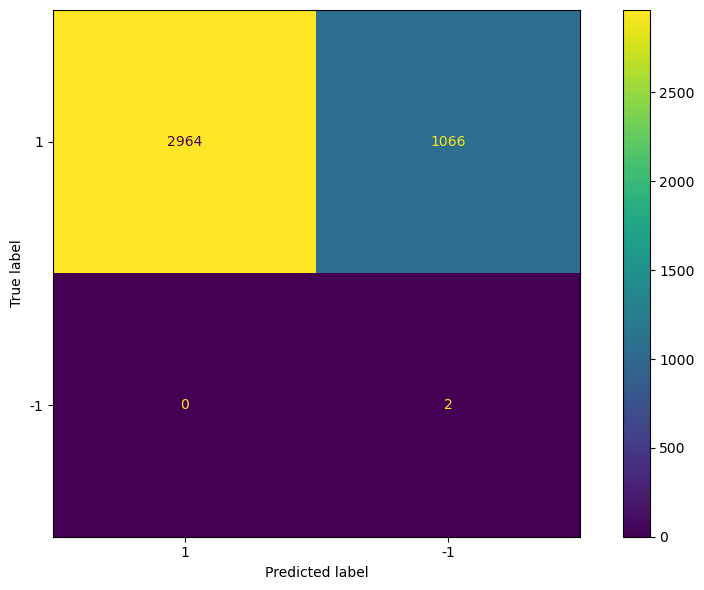

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ilki gerçekte olan, ikincisi bizim tahmin ettiğimiz
cm = confusion_matrix(df['is_anomaly'], df['baseline'], labels=[1, -1]) # ilk hangi etiketi yazarsan onu üstte gösteriyor. 

disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1, -1]) # aynı sırada olmalı

disp_cm.plot();

plt.grid(False)
plt.tight_layout()

**2 tane outlier vardı 2'sini de doğru bilmişiz. Fakat outlier olmamasına rağmen 1066 değere outlier demişiz.**

## <font color='blue'>Isolation forest </font>

In [25]:
from sklearn.ensemble import IsolationForest

In [26]:
anomalies_timestamp = [
        "2014-02-26 22:05:00",
        "2014-02-27 17:15:00"
    ]

In [27]:
df = pd.read_csv('./data/ec2_cpu_utilization.csv')

df['timestamp'] = pd.to_datetime(df['timestamp'])
df['is_anomaly'] = 1

for each in anomalies_timestamp:
    df.loc[df['timestamp'] == each, 'is_anomaly'] = -1
    
df.head()

,timestamp,value,is_anomaly
0,2014-02-14 14:30:00,0.132,1
1,2014-02-14 14:35:00,0.134,1
2,2014-02-14 14:40:00,0.134,1
3,2014-02-14 14:45:00,0.134,1
4,2014-02-14 14:50:00,0.134,1


In [28]:
# bir anomali trainde, diğeri test setinde kaldı. 
# df[df['timestamp'] == "2014-02-26 22:05:00"]
# df[df['timestamp'] == "2014-02-27 17:15:00"]

In [29]:
train = df[:3550]
test = df[3550:]

**Contamination level belirlememiz lazım. Contamination train setindeki anomali sayısıdır. Biz biliyoruz şu anda. Train setimizde 1 adet anomali vardı.Normalde elimizdeki datada verilmişse bize anomaliler biz de bu şekilde yapabiliriz ama genelde belli olmuyor.** 

In [30]:
contamination = 1/len(train)

iso_forest = IsolationForest(contamination=contamination, random_state=42)

X_train = train['value'].values.reshape(-1,1)

iso_forest.fit(X_train)

IsolationForest(contamination=0.00028169014084507044, random_state=42)

In [31]:
# df.loc[3540:3550]

In [32]:
# df[df['timestamp'] == "2014-02-26 22:05:00"]

In [33]:
preds_iso_forest = iso_forest.predict(test['value'].values.reshape(-1,1))

In [34]:
preds_iso_forest

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

### <font color='black'>**Evaluation**</font>

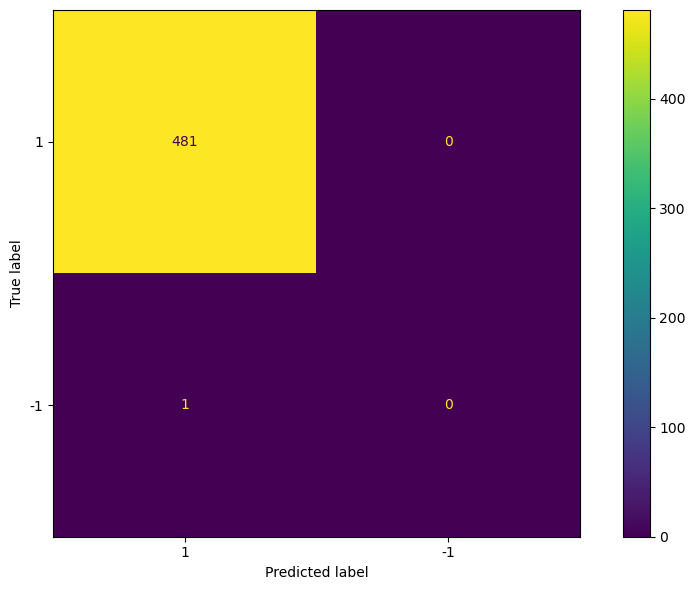

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test['is_anomaly'], preds_iso_forest, labels=[1, -1]) # sadece test setimize bakıyoruz.

disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1, -1])

disp_cm.plot();

plt.grid(False)
plt.tight_layout()

**Test setindeki anomaliyi yakalayamadı. Tüm noktalara inlier dedi.** 

## <font color='blue'>Local outlier factor (LOF)  </font>

In [36]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(contamination=contamination, novelty=True)

lof.fit(X_train)

LocalOutlierFactor(contamination=0.00028169014084507044, novelty=True)

In [37]:
preds_lof = lof.predict(test['value'].values.reshape(-1,1))

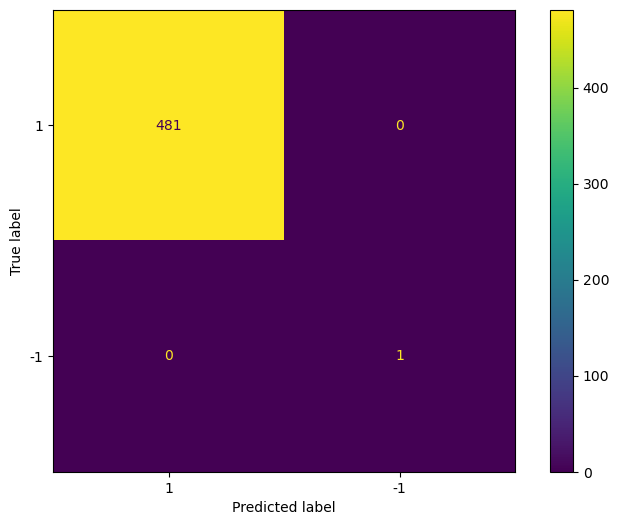

In [38]:
cm = confusion_matrix(test['is_anomaly'], preds_lof, labels=[1, -1])

disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1, -1])

disp_cm.plot();

**LOF test setindeki anomaliyi yakalayabildi ve hatta anomali olmayanlara da anomali değil dedi. Şu anda mükemmel bir confusion matris elde ettik.**